## Gesture Recognition 


In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed(30)

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='Project_data'
project_folder

'Project_data'

##### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, We are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [7]:
class ModelBuilder(metaclass = abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also Keeping in mind that the last layer is the softmax. 

## Sample Model

In [8]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

## Experimenting with Image resolution, number of frames to use and batch_size

In [10]:
conv_3d1.train_model(conv_3d1_model)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/max_pooling3d_1/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, _class=["loc:@training/Adam/gradients/batch_normalization_1/cond/Merge_grad/cond_grad"], data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](batch_normalization_1/cond/Merge, max_pooling3d_1/MaxPool3D, training/Adam/gradients/conv3d_2/convolution_grad/Conv3DBackpropInputV2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


###We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error



In [11]:
import sys
print("Memory util is {} Gigs". format(sys.getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 110s 5s/step - loss: 1.5394 - categorical_accuracy: 0.4237 - val_loss: 3.3725 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-12-2618_32_26.367956/model-00001-1.59190-0.40121-3.37249-0.36000.h5
Epoch 2/3
23/23 [==============================] - 50s 2s/step - loss: 1.0077 - categorical_accuracy: 0.5999 - val_loss: 0.8325 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2020-12-2618_32_26.367956/model-00002-1.00848-0.59729-0.83250-0.65000.h5
Epoch 3/3
23/23 [==============================] - 53s 2s/step - loss: 0.8542 - categorical_accuracy: 0.6521 - val_loss: 2.0199 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-12-2618_32_26.367956/model-00003-0.86396-0.65158-2.01989-0.51000.h5


In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 144s 6s/step - loss: 1.6634 - categorical_accuracy: 0.3856 - val_loss: 2.2760 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-12-2618_36_07.814975/model-00001-1.69503-0.38763-2.27600-0.36000.h5
Epoch 2/2
23/23 [==============================] - 70s 3s/step - loss: 1.2583 - categorical_accuracy: 0.5081 - val_loss: 2.1909 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2020-12-2618_36_07.814975/model-00002-1.20731-0.52790-2.19091-0.38000.h5


In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 87s 7s/step - loss: 1.6906 - categorical_accuracy: 0.3599 - val_loss: 1.1237 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-12-2618_39_50.145867/model-00001-1.73172-0.36199-1.12375-0.52000.h5
Epoch 2/2
12/12 [==============================] - 68s 6s/step - loss: 1.0607 - categorical_accuracy: 0.5389 - val_loss: 1.3039 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-12-2618_39_50.145867/model-00002-1.07981-0.55505-1.30388-0.55000.h5


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 48s 4s/step - loss: 1.8015 - categorical_accuracy: 0.3591 - val_loss: 4.2355 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-12-2618_42_37.881191/model-00001-1.89464-0.33484-4.23549-0.26000.h5
Epoch 2/2
12/12 [==============================] - 35s 3s/step - loss: 1.1292 - categorical_accuracy: 0.5632 - val_loss: 1.9671 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-12-2618_42_37.881191/model-00002-1.15538-0.55505-1.96708-0.41000.h5


In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 48s 5s/step - loss: 1.7912 - categorical_accuracy: 0.3495 - val_loss: 2.2668 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2020-12-2618_44_10.392070/model-00001-1.78012-0.35294-2.26680-0.32000.h5
Epoch 2/2
9/9 [==============================] - 34s 4s/step - loss: 1.2282 - categorical_accuracy: 0.5151 - val_loss: 2.1871 - val_categorical_accuracy: 0.4200

Epoch 00002: saving model to model_init_2020-12-2618_44_10.392070/model-00002-1.21651-0.52790-2.18710-0.42000.h5


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 95s 2s/step - loss: 1.6317 - categorical_accuracy: 0.3926 - val_loss: 1.0789 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2020-12-2618_45_43.944187/model-00001-1.63001-0.39367-1.07895-0.57000.h5
Epoch 2/2
45/45 [==============================] - 82s 2s/step - loss: 1.1614 - categorical_accuracy: 0.5290 - val_loss: 1.4859 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-12-2618_45_43.944187/model-00002-1.15793-0.53243-1.48589-0.44000.h5


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 51s 1s/step - loss: 1.5828 - categorical_accuracy: 0.4120 - val_loss: 3.4898 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-12-2618_48_49.588787/model-00001-1.56456-0.41931-3.48977-0.23000.h5
Epoch 2/2
45/45 [==============================] - 41s 911ms/step - loss: 1.1689 - categorical_accuracy: 0.5438 - val_loss: 1.0013 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-12-2618_48_49.588787/model-00002-1.16859-0.54751-1.00133-0.59000.h5


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - 41s 915ms/step - loss: 1.7209 - categorical_accuracy: 0.3867 - val_loss: 1.5352 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-12-2618_50_31.372132/model-00001-1.68478-0.38763-1.53517-0.44000.h5
Epoch 2/2
45/45 [==============================] - 32s 709ms/step - loss: 1.1577 - categorical_accuracy: 0.5304 - val_loss: 0.9335 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-12-2618_50_31.372132/model-00002-1.13955-0.53394-0.93352-0.66000.h5


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 41s 617ms/step - loss: 1.6545 - categorical_accuracy: 0.3871 - val_loss: 1.6757 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-12-2618_51_54.125511/model-00001-1.66137-0.38763-1.67574-0.35000.h5
Epoch 2/2
67/67 [==============================] - 33s 496ms/step - loss: 1.3507 - categorical_accuracy: 0.4946 - val_loss: 1.2655 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-12-2618_51_54.125511/model-00002-1.33964-0.49623-1.26547-0.56000.h5


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 76s 1s/step - loss: 1.5995 - categorical_accuracy: 0.3911 - val_loss: 1.3087 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-12-2618_53_19.102403/model-00001-1.59223-0.39517-1.30867-0.52000.h5
Epoch 2/2
67/67 [==============================] - 67s 996ms/step - loss: 1.1641 - categorical_accuracy: 0.5398 - val_loss: 2.3895 - val_categorical_accuracy: 0.3200

Epoch 00002: saving model to model_init_2020-12-2618_53_19.102403/model-00002-1.16787-0.53846-2.38951-0.32000.h5


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 93s 1s/step - loss: 1.6876 - categorical_accuracy: 0.4129 - val_loss: 1.2596 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2020-12-2618_55_52.063140/model-00001-1.68894-0.41026-1.25958-0.60000.h5
Epoch 2/2
67/67 [==============================] - 80s 1s/step - loss: 1.2546 - categorical_accuracy: 0.5432 - val_loss: 3.0161 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-12-2618_55_52.063140/model-00002-1.26397-0.53846-3.01610-0.30000.h5


In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - 51s 763ms/step - loss: 1.5525 - categorical_accuracy: 0.4248 - val_loss: 1.1263 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-12-2618_58_57.487664/model-00001-1.55954-0.42232-1.12625-0.58000.h5
Epoch 2/2
67/67 [==============================] - 41s 610ms/step - loss: 1.2492 - categorical_accuracy: 0.5189 - val_loss: 1.0536 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-12-2618_58_57.487664/model-00002-1.25362-0.51735-1.05364-0.60000.h5


In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - 56s 3s/step - loss: 1.8093 - categorical_accuracy: 0.3437 - val_loss: 1.1423 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-12-2619_00_40.986617/model-00001-1.81898-0.33937-1.14231-0.46000.h5
Epoch 2/2
17/17 [==============================] - 36s 2s/step - loss: 1.0795 - categorical_accuracy: 0.5755 - val_loss: 0.8783 - val_categorical_accuracy: 0.6700

Epoch 00002: saving model to model_init_2020-12-2619_00_40.986617/model-00002-1.07567-0.57466-0.87828-0.67000.h5


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [25]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_58 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 10, 80, 80, 32)    128       
__________

In [27]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 72s 4s/step - loss: 1.7245 - categorical_accuracy: 0.3761 - val_loss: 4.9787 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-12-2619_02_27.115015/model-00001-1.73942-0.37255-4.97867-0.23000.h5
Epoch 2/15
17/17 [==============================] - 60s 4s/step - loss: 1.1686 - categorical_accuracy: 0.5316 - val_loss: 1.8293 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-12-2619_02_27.115015/model-00002-1.16397-0.53394-1.82932-0.41000.h5
Epoch 3/15
17/17 [==============================] - 60s 4s/step - loss: 0.8652 - categorical_accuracy: 0.6653 - val_loss: 0.8613 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-12-2619_02_27.115015/model-00003-0.86837-0.66667-0.86125-0.69000.h5
Epoch 4/15
17/17 [==============================] - 56s 3s/step - loss: 0.6901 - categorical_accuracy: 0.7317 - val_loss: 0.8955 - val_categoric

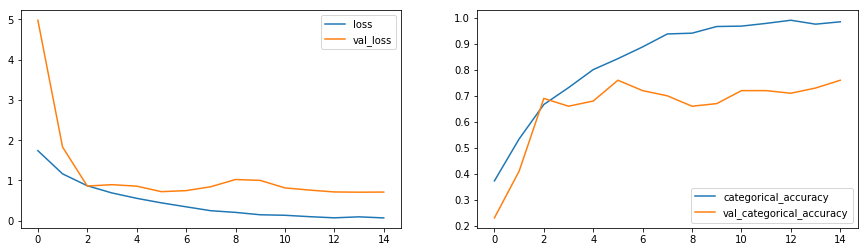

In [28]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [29]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_62 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 10, 80, 80, 32)    128       
__________

In [30]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 139s 4s/step - loss: 1.9245 - categorical_accuracy: 0.3771 - val_loss: 1.5148 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-12-2619_17_10.593113/model-00001-1.92774-0.37406-1.51480-0.48000.h5
Epoch 2/25
34/34 [==============================] - 118s 3s/step - loss: 1.4802 - categorical_accuracy: 0.4812 - val_loss: 1.7439 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-12-2619_17_10.593113/model-00002-1.46081-0.48492-1.74391-0.51000.h5
Epoch 3/25
34/34 [==============================] - 129s 4s/step - loss: 1.2382 - categorical_accuracy: 0.5589 - val_loss: 1.1146 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-12-2619_17_10.593113/model-00003-1.24094-0.56033-1.11461-0.65000.h5
Epoch 4/25
34/34 [==============================] - 128s 4s/step - loss: 1.0813 - categorical_accuracy: 0.6115 - val_loss: 4.9896 - val_categ

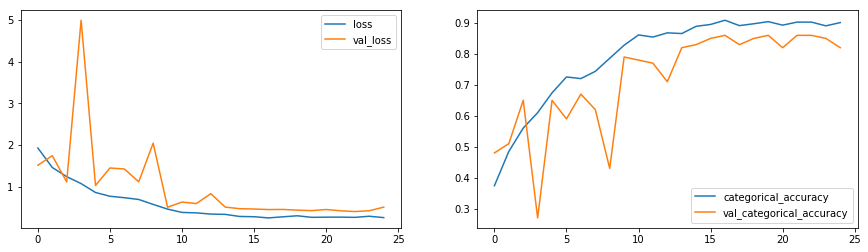

In [31]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 82% and training accuracy of 89%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [32]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_66 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_98 (Batc (None, 8, 60, 60, 32)     128       
__________

In [34]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 109s 5s/step - loss: 2.1016 - categorical_accuracy: 0.3362 - val_loss: 1.1081 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-12-2620_11_17.213693/model-00001-2.10812-0.33635-1.10813-0.58000.h5
Epoch 2/30
23/23 [==============================] - 74s 3s/step - loss: 1.4199 - categorical_accuracy: 0.4978 - val_loss: 0.9463 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-12-2620_11_17.213693/model-00002-1.42866-0.49774-0.94629-0.66000.h5
Epoch 3/30
23/23 [==============================] - 84s 4s/step - loss: 1.3248 - categorical_accuracy: 0.5576 - val_loss: 0.8147 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-12-2620_11_17.213693/model-00003-1.27674-0.56637-0.81469-0.67000.h5
Epoch 4/30
23/23 [==============================] - 85s 4s/step - loss: 1.1331 - categorical_accuracy: 0.5965 - val_loss: 0.8761 - val_categori

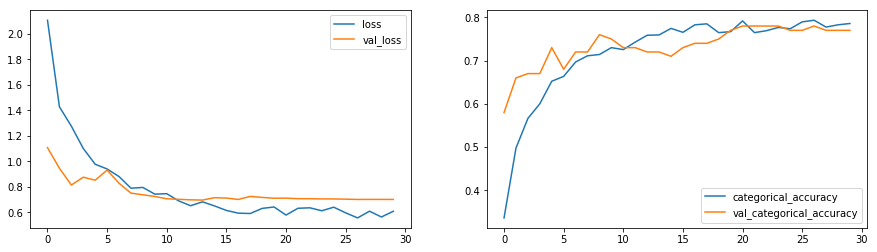

In [35]:
plot(history_model3)

##### Model has a  best validation accuracy of 76% and training accuracy of 77% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [36]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_69 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_69 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_70 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [38]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 122s 4s/step - loss: 2.0125 - categorical_accuracy: 0.3536 - val_loss: 8.3133 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2020-12-2620_54_13.224903/model-00001-2.04081-0.34992-8.31334-0.26000.h5
Epoch 2/30
34/34 [==============================] - 96s 3s/step - loss: 1.5723 - categorical_accuracy: 0.4570 - val_loss: 4.8357 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-12-2620_54_13.224903/model-00002-1.57970-0.45173-4.83571-0.31000.h5
Epoch 3/30
34/34 [==============================] - 96s 3s/step - loss: 1.3747 - categorical_accuracy: 0.5088 - val_loss: 1.2522 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-12-2620_54_13.224903/model-00003-1.35822-0.51735-1.25219-0.54000.h5
Epoch 4/30
34/34 [==============================] - 96s 3s/step - loss: 1.3236 - categorical_accuracy: 0.5158 - val_loss: 1.7767 - val_categori

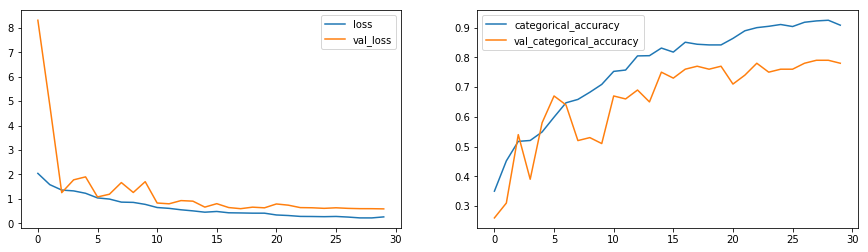

In [39]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 78% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [40]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_77 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_77 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_78 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [42]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - 110s 3s/step - loss: 1.8123 - categorical_accuracy: 0.3771 - val_loss: 1.4748 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2020-12-2621_43_03.974210/model-00001-1.82237-0.37406-1.47477-0.52000.h5
Epoch 2/22
34/34 [==============================] - 96s 3s/step - loss: 1.3453 - categorical_accuracy: 0.4919 - val_loss: 1.1858 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-12-2621_43_03.974210/model-00002-1.35945-0.49170-1.18585-0.60000.h5
Epoch 3/22
34/34 [==============================] - 96s 3s/step - loss: 1.2012 - categorical_accuracy: 0.5427 - val_loss: 1.5737 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-12-2621_43_03.974210/model-00003-1.20955-0.54374-1.57366-0.51000.h5
Epoch 4/22
34/34 [==============================] - 97s 3s/step - loss: 1.0753 - categorical_accuracy: 0.5813 - val_loss: 1.4731 - val_categori

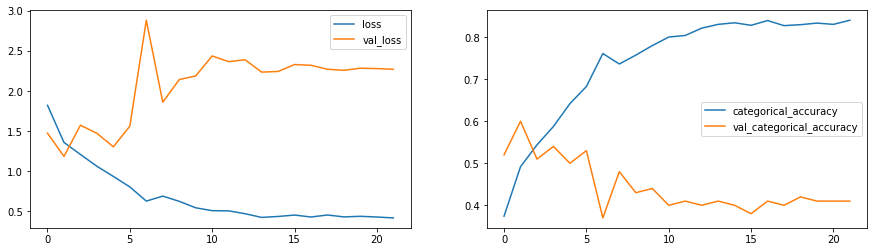

In [43]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [44]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_85 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_85 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_123 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_77 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_86 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 8, 50, 50, 32)     128       
__________

In [46]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 85s 3s/step - loss: 1.8736 - categorical_accuracy: 0.3561 - val_loss: 1.2088 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-12-2622_19_12.567088/model-00001-1.84336-0.36501-1.20876-0.49000.h5
Epoch 2/30
34/34 [==============================] - 67s 2s/step - loss: 1.2432 - categorical_accuracy: 0.5280 - val_loss: 1.3190 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-12-2622_19_12.567088/model-00002-1.19481-0.53695-1.31904-0.59000.h5
Epoch 3/30
34/34 [==============================] - 79s 2s/step - loss: 1.0455 - categorical_accuracy: 0.6104 - val_loss: 0.9781 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-12-2622_19_12.567088/model-00003-1.02839-0.61312-0.97813-0.61000.h5
Epoch 4/30
34/34 [==============================] - 79s 2s/step - loss: 0.8959 - categorical_accuracy: 0.6659 - val_loss: 0.9146 - val_categorica

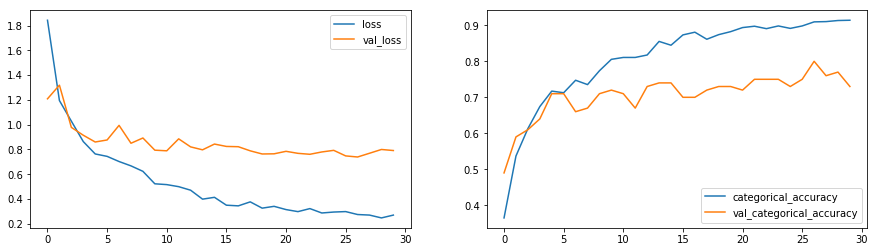

In [47]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 73%

# Model 7 - reducing the number of parameters

In [48]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_89 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_89 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_81 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_90 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 8, 60, 60, 32)     128       
__________

In [50]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 93s 3s/step - loss: 1.7697 - categorical_accuracy: 0.3572 - val_loss: 1.2968 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2020-12-2622_59_28.751025/model-00001-1.75958-0.36199-1.29682-0.47000.h5
Epoch 2/25
34/34 [==============================] - 74s 2s/step - loss: 1.2754 - categorical_accuracy: 0.5026 - val_loss: 1.1716 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-12-2622_59_28.751025/model-00002-1.26909-0.50679-1.17156-0.53000.h5
Epoch 3/25
34/34 [==============================] - 85s 3s/step - loss: 1.0329 - categorical_accuracy: 0.6085 - val_loss: 1.0121 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2020-12-2622_59_28.751025/model-00003-1.03584-0.60709-1.01206-0.60000.h5
Epoch 4/25
34/34 [==============================] - 86s 3s/step - loss: 0.9244 - categorical_accuracy: 0.6461 - val_loss: 0.9284 - val_categorica

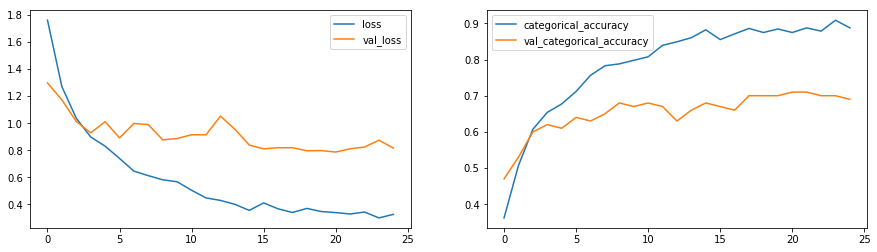

In [51]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 69%

# Model 8 - reducing the number of parameters

In [52]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_93 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_93 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_135 (Bat (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_85 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_94 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 8, 60, 60, 16)     64        
__________

In [54]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 92s 3s/step - loss: 2.0346 - categorical_accuracy: 0.3054 - val_loss: 1.4218 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-12-2623_35_42.723747/model-00001-2.02790-0.30468-1.42175-0.38000.h5
Epoch 2/30
34/34 [==============================] - 72s 2s/step - loss: 1.5960 - categorical_accuracy: 0.4091 - val_loss: 1.0768 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-12-2623_35_42.723747/model-00002-1.59197-0.41101-1.07675-0.50000.h5
Epoch 3/30
34/34 [==============================] - 85s 2s/step - loss: 1.3357 - categorical_accuracy: 0.4628 - val_loss: 1.3641 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-12-2623_35_42.723747/model-00003-1.32725-0.46606-1.36412-0.40000.h5
Epoch 4/30
34/34 [==============================] - 85s 2s/step - loss: 1.2380 - categorical_accuracy: 0.5026 - val_loss: 1.2151 - val_categorica

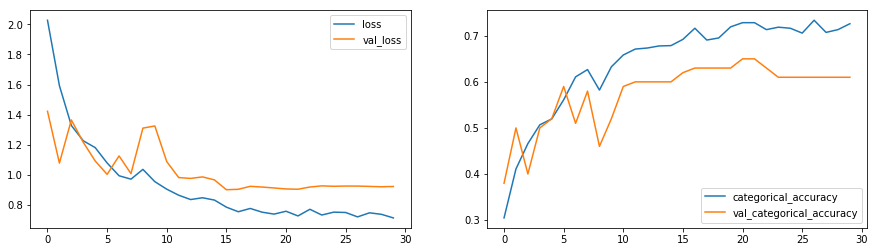

In [55]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 61%

# Model 9 - CNN- LSTM Model

In [11]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [13]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 199s 6s/step - loss: 1.3825 - categorical_accuracy: 0.4180 - val_loss: 1.1589 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-12-2702_53_45.286194/model-00001-1.39116-0.41176-1.15895-0.53000.h5
Epoch 2/20
34/34 [==============================] - 115s 3s/step - loss: 1.1020 - categorical_accuracy: 0.5364 - val_loss: 0.9857 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-12-2702_53_45.286194/model-00002-1.10306-0.54148-0.98566-0.58000.h5
Epoch 3/20
34/34 [==============================] - 121s 4s/step - loss: 0.9469 - categorical_accuracy: 0.6177 - val_loss: 0.9969 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-12-2702_53_45.286194/model-00003-0.96020-0.61237-0.99694-0.62000.h5
Epoch 4/20
34/34 [==============================] - 114s 3s/step - loss: 0.8533 - categorical_accuracy: 0.6656 - val_loss: 1.0599 - val_categ

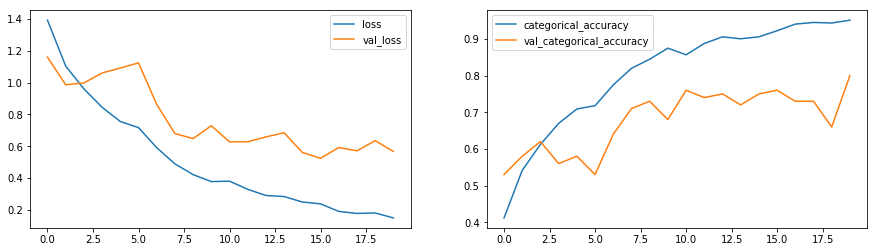

In [14]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 80%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [8]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [13]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)    128       
__________

In [18]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 140s 4s/step - loss: 0.3319 - categorical_accuracy: 0.8727 - val_loss: 0.5600 - val_categorical_accuracy: 0.8100

Epoch 00001: saving model to model_init_2020-12-2709_43_11.615750/model-00001-0.31242-0.88612-0.56001-0.81000.h5
Epoch 2/30
34/34 [==============================] - 131s 4s/step - loss: 0.2704 - categorical_accuracy: 0.8977 - val_loss: 0.5624 - val_categorical_accuracy: 0.8100

Epoch 00002: saving model to model_init_2020-12-2709_43_11.615750/model-00002-0.26177-0.90347-0.56238-0.81000.h5
Epoch 3/30
34/34 [==============================] - 132s 4s/step - loss: 0.2854 - categorical_accuracy: 0.8929 - val_loss: 0.5602 - val_categorical_accuracy: 0.8100

Epoch 00003: saving model to model_init_2020-12-2709_43_11.615750/model-00003-0.28808-0.89442-0.56017-0.81000.h5
Epoch 4/30
34/34 [==============================] - 135s 4s/step - loss: 0.3239 - categorical_accuracy: 0.8882 - val_loss: 0.5589 - val_categ

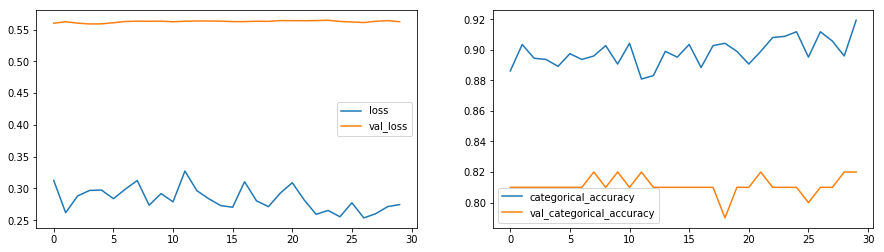

In [19]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [14]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [16]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - 132s 6s/step - loss: 2.2589 - categorical_accuracy: 0.2979 - val_loss: 1.1141 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-12-2710_55_50.951310/model-00001-2.31374-0.28356-1.11412-0.54000.h5
Epoch 2/30
23/23 [==============================] - 85s 4s/step - loss: 1.6084 - categorical_accuracy: 0.4437 - val_loss: 1.0887 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-12-2710_55_50.951310/model-00002-1.58878-0.44796-1.08866-0.60000.h5
Epoch 3/30
23/23 [==============================] - 85s 4s/step - loss: 1.4090 - categorical_accuracy: 0.5295 - val_loss: 1.0859 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-12-2710_55_50.951310/model-00003-1.37167-0.52413-1.08588-0.57000.h5
Epoch 4/30
23/23 [==============================] - 83s 4s/step - loss: 1.2802 - categorical_accuracy: 0.5501 - val_loss: 1.0281 - val_categori

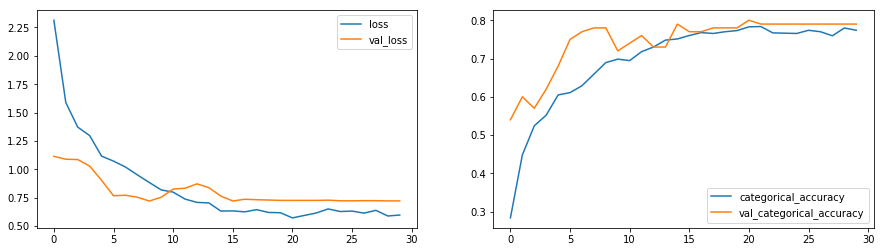

In [17]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [18]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [20]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - 111s 3s/step - loss: 2.0020 - categorical_accuracy: 0.3521 - val_loss: 1.2731 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-12-2711_39_09.192477/model-00001-2.00833-0.34842-1.27311-0.54000.h5
Epoch 2/30
34/34 [==============================] - 92s 3s/step - loss: 1.6579 - categorical_accuracy: 0.4444 - val_loss: 1.4445 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-12-2711_39_09.192477/model-00002-1.62363-0.44721-1.44446-0.47000.h5
Epoch 3/30
34/34 [==============================] - 94s 3s/step - loss: 1.4594 - categorical_accuracy: 0.4901 - val_loss: 1.2288 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-12-2711_39_09.192477/model-00003-1.44691-0.49397-1.22876-0.58000.h5
Epoch 4/30
34/34 [==============================] - 99s 3s/step - loss: 1.3380 - categorical_accuracy: 0.5375 - val_loss: 0.9213 - val_categori

In [9]:
plot(history_model12)

NameError: name 'history_model12' is not defined

# Model 13 - Adding dropouts - Similar to Model 5

In [10]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [12]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 220s 6s/step - loss: 2.0681 - categorical_accuracy: 0.3057 - val_loss: 3.5566 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-12-2715_20_22.338671/model-00001-2.04165-0.30920-3.55657-0.24000.h5
Epoch 2/25
34/34 [==============================] - 99s 3s/step - loss: 1.6591 - categorical_accuracy: 0.4110 - val_loss: 4.0531 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-12-2715_20_22.338671/model-00002-1.65481-0.40875-4.05312-0.23000.h5
Epoch 3/25
34/34 [==============================] - 99s 3s/step - loss: 1.4857 - categorical_accuracy: 0.4481 - val_loss: 3.6401 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2020-12-2715_20_22.338671/model-00003-1.48624-0.45098-3.64014-0.26000.h5
Epoch 4/25
34/34 [==============================] - 99s 3s/step - loss: 1.2741 - categorical_accuracy: 0.5224 - val_loss: 3.5325 - val_categori

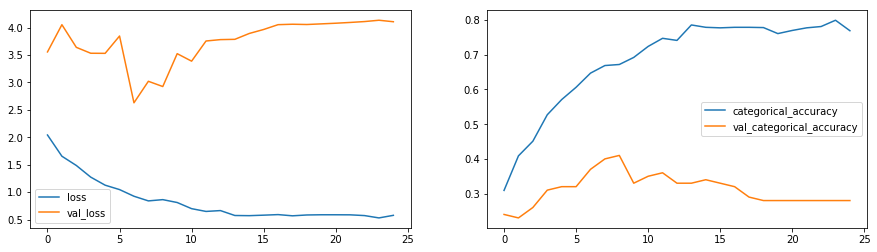

In [13]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [14]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 50, 50, 32)     128       
__________

In [16]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - 85s 3s/step - loss: 1.8686 - categorical_accuracy: 0.3201 - val_loss: 1.1686 - val_categorical_accuracy: 0.5000

Epoch 00001: saving model to model_init_2020-12-2716_04_00.510233/model-00001-1.85375-0.31976-1.16865-0.50000.h5
Epoch 2/30
34/34 [==============================] - 77s 2s/step - loss: 1.3802 - categorical_accuracy: 0.4812 - val_loss: 0.9241 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2020-12-2716_04_00.510233/model-00002-1.35495-0.48492-0.92408-0.63000.h5
Epoch 3/30
34/34 [==============================] - 80s 2s/step - loss: 1.1415 - categorical_accuracy: 0.5533 - val_loss: 1.0429 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2020-12-2716_04_00.510233/model-00003-1.13563-0.55882-1.04290-0.62000.h5
Epoch 4/30
34/34 [==============================] - 80s 2s/step - loss: 1.0310 - categorical_accuracy: 0.5843 - val_loss: 1.0198 - val_categorica

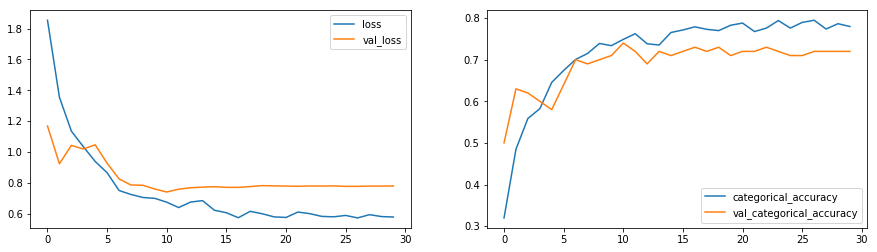

In [17]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [18]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_14 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 60, 60, 32)     128       
__________

In [20]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 95s 3s/step - loss: 1.7830 - categorical_accuracy: 0.3385 - val_loss: 1.0459 - val_categorical_accuracy: 0.6200

Epoch 00001: saving model to model_init_2020-12-2716_45_11.841628/model-00001-1.79413-0.34691-1.04589-0.62000.h5
Epoch 2/25
34/34 [==============================] - 88s 3s/step - loss: 1.2302 - categorical_accuracy: 0.5320 - val_loss: 1.0051 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-12-2716_45_11.841628/model-00002-1.23552-0.52866-1.00510-0.66000.h5
Epoch 3/25
34/34 [==============================] - 89s 3s/step - loss: 1.0376 - categorical_accuracy: 0.6181 - val_loss: 0.8003 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-12-2716_45_11.841628/model-00003-0.97961-0.62519-0.80026-0.66000.h5
Epoch 4/25
34/34 [==============================] - 90s 3s/step - loss: 0.9069 - categorical_accuracy: 0.6501 - val_loss: 0.8415 - val_categorica

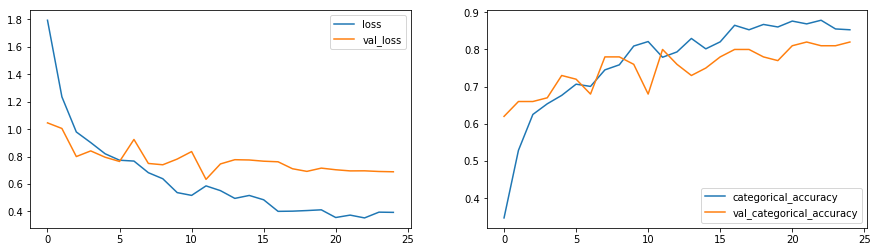

In [21]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [22]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 60, 60, 16)     64        
__________

In [24]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 93s 3s/step - loss: 2.0226 - categorical_accuracy: 0.2693 - val_loss: 1.6594 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2020-12-2717_22_59.104178/model-00001-2.02706-0.26772-1.65938-0.34000.h5
Epoch 2/30
34/34 [==============================] - 86s 3s/step - loss: 1.5101 - categorical_accuracy: 0.4253 - val_loss: 1.4213 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-12-2717_22_59.104178/model-00002-1.51713-0.42760-1.42128-0.41000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.3838 - categorical_accuracy: 0.4481 - val_loss: 1.2631 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_2020-12-2717_22_59.104178/model-00003-1.36295-0.45098-1.26311-0.53000.h5
Epoch 4/30
34/34 [==============================] - 88s 3s/step - loss: 1.2807 - categorical_accuracy: 0.4948 - val_loss: 1.1815 - val_categorica

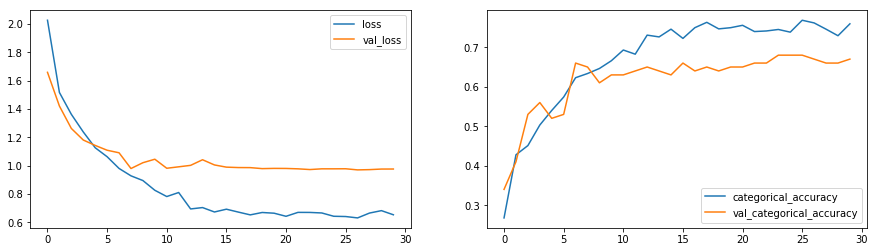

In [25]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [26]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [28]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 156s 5s/step - loss: 1.4700 - categorical_accuracy: 0.3771 - val_loss: 1.1610 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-12-2718_07_07.091431/model-00001-1.48091-0.37406-1.16097-0.58000.h5
Epoch 2/20
34/34 [==============================] - 96s 3s/step - loss: 1.0889 - categorical_accuracy: 0.5625 - val_loss: 1.0617 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2020-12-2718_07_07.091431/model-00002-1.10074-0.55581-1.06174-0.58000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.9207 - categorical_accuracy: 0.6339 - val_loss: 0.9205 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-12-2718_07_07.091431/model-00003-0.91422-0.63725-0.92049-0.63000.h5
Epoch 4/20
34/34 [==============================] - 100s 3s/step - loss: 0.7771 - categorical_accuracy: 0.7163 - val_loss: 0.8996 - val_catego

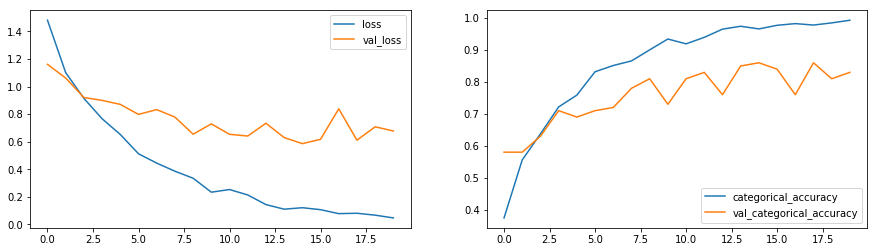

In [29]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [30]:
from keras.applications import mobilenet

In [31]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [32]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
__________

In [33]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 92s 689ms/step - loss: 1.5120 - categorical_accuracy: 0.3288 - val_loss: 1.3149 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-12-2718_41_12.412670/model-00001-1.51304-0.32881-1.31486-0.40000.h5
Epoch 2/20
133/133 [==============================] - 83s 623ms/step - loss: 1.2840 - categorical_accuracy: 0.4654 - val_loss: 1.2259 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-12-2718_41_12.412670/model-00002-1.28417-0.46531-1.22587-0.50000.h5
Epoch 3/20
133/133 [==============================] - 84s 628ms/step - loss: 1.0338 - categorical_accuracy: 0.6003 - val_loss: 1.0973 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2020-12-2718_41_12.412670/model-00003-1.03203-0.60106-1.09730-0.51000.h5
Epoch 4/20
133/133 [==============================] - 86s 645ms/step - loss: 0.8995 - categorical_accuracy: 0.6534 - val_loss: 1.

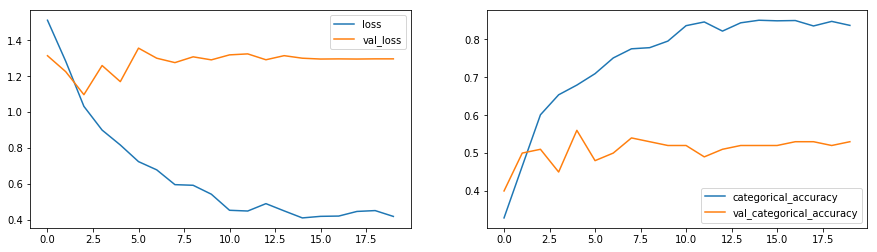

In [34]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [9]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [10]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [11]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 204s 2s/step - loss: 1.2350 - categorical_accuracy: 0.4717 - val_loss: 0.7209 - val_categorical_accuracy: 0.7700

Epoch 00001: saving model to model_init_2020-12-2805_54_50.289380/model-00001-1.23706-0.47059-0.72092-0.77000.h5
Epoch 2/20
133/133 [==============================] - 118s 884ms/step - loss: 0.7214 - categorical_accuracy: 0.7143 - val_loss: 0.4824 - val_categorical_accuracy: 0.8500

Epoch 00002: saving model to model_init_2020-12-2805_54_50.289380/model-00002-0.72248-0.71342-0.48238-0.85000.h5
Epoch 3/20
133/133 [==============================] - 130s 977ms/step - loss: 0.4180 - categorical_accuracy: 0.8356 - val_loss: 1.5702 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-12-2805_54_50.289380/model-00003-0.41781-0.83560-1.57020-0.56000.h5
Epoch 4/20
133/133 [==============================] - 98s 739ms/step - loss: 0.4792 - categorical_accuracy: 0.8183 - val_loss: 0.

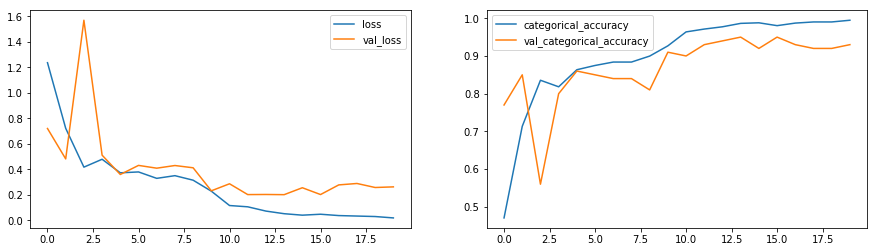

In [12]:
plot(history_model19)

# Consolidated Final Models

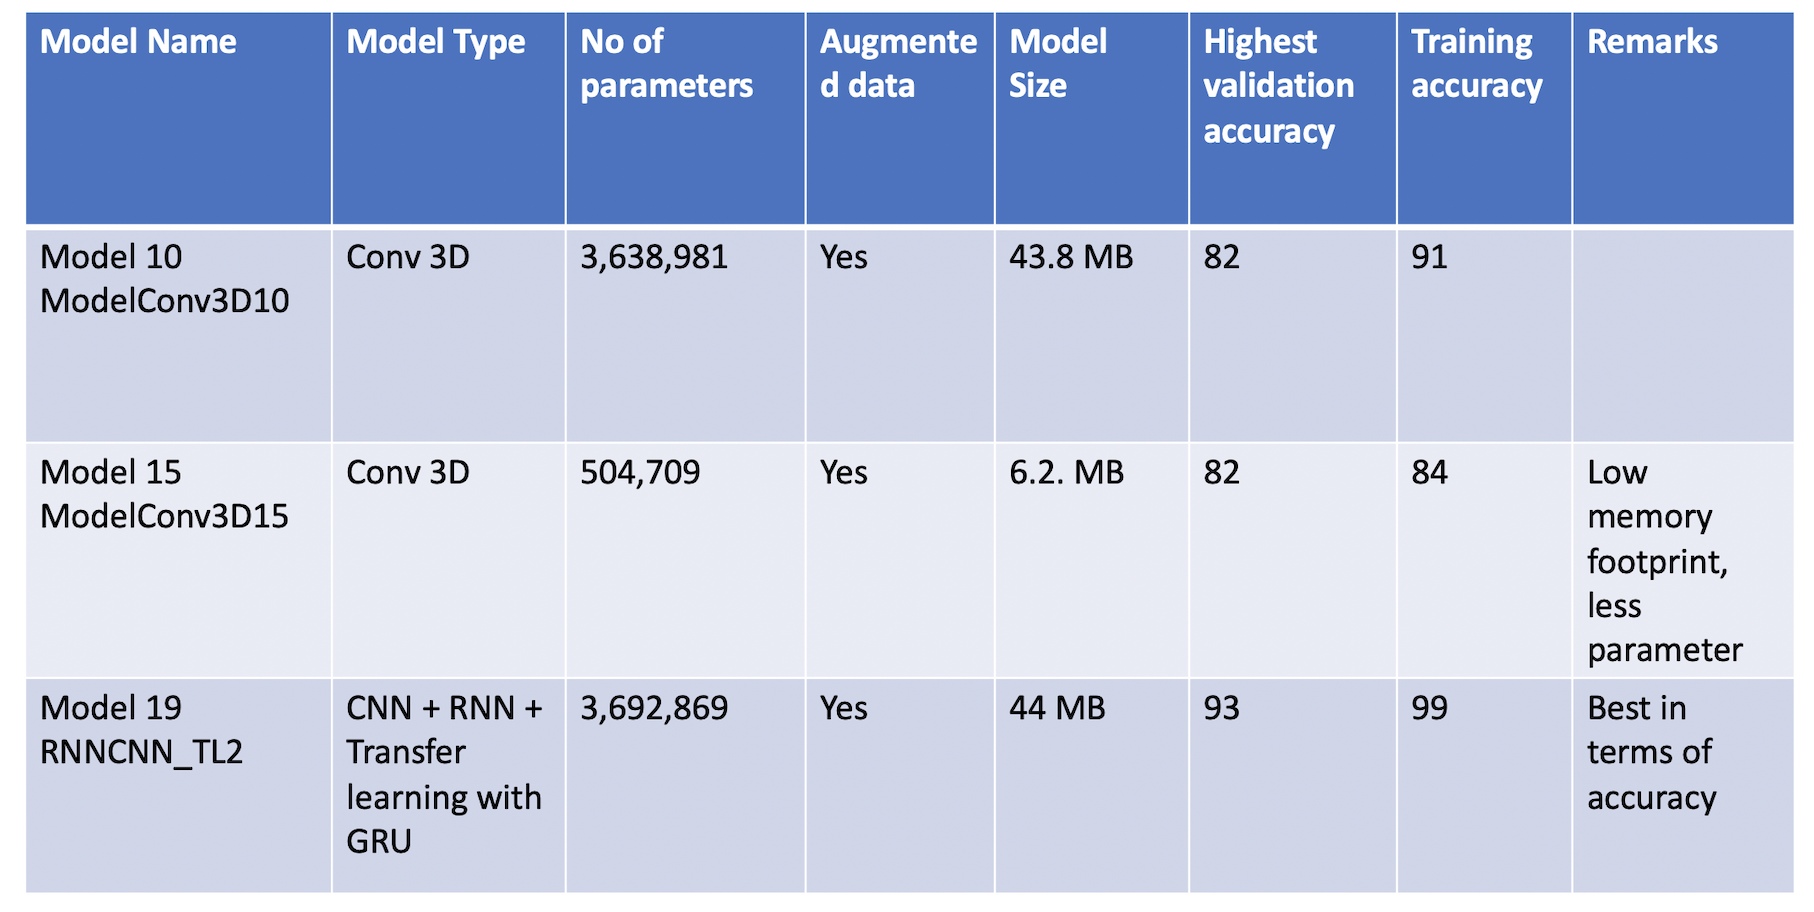

#####  Since Model 15 has less number of parameter and has good Accuracy across training and validation data, we are picking model model 15 for evaliuation.

# Loading model and Testing

In [15]:
import time
from keras.models import load_model
model = load_model('model_init_2020-12-2716_45_11.841628/model-00025-0.39337-0.85294-0.68930-0.82000.h5')

In [16]:
test_generator=ModelConv3D15()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [17]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [18]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 0 2 2 2]
